# 3. Working with data

<div style="background-color:wheat">
<strong>Goal of this notebook.</strong>
<ul style="margin-top: 0px">
<li>Get used to the standard ways of thinking about data, _data frames_ and _indexed tables_</li>
<li>Learn how to use the <a href="http://pandas.pydata.org/">Pandas</a> library to handle data</li>
<li>See some more advanced plotting with <a href="https://matplotlib.org/">matplotlib</a></li>
</ul>

## 3.0 Preamble

At the top of almost every piece of data-oriented scientific computing work, we'll import these standard modules.

In [41]:
# Import modules, and give them short aliases so we can write e.g. np.foo rather than numpy.foo
import numpy as np
import pandas
import matplotlib
import matplotlib.pyplot as plt
# The next line is a piece of magic, to let plots appear in our Jupyter notebooks
%matplotlib inline 

The running example for this section is a dataset of stop-and-search records, [made available](https://data.police.uk/data/) by the UK home office. It's a large file, 172MB, so I like to download it to disk, so it's fast to read it each time I restart the notebook. Here's how we can fetch a file from a url, using the Unix command-line tool `wget`. (The exclamation mark is called a _Jupyter magic_, and it means "Treat this line as though it were executed at the command prompt". In IB _Unix Tools_ you'll learn more about the Unix command line.)

In [11]:
# Execute a unix command to download a file (if it's not already downloaded), and show download progress
!if [ -e "stop-and-search.csv" ]; then echo "file already downloaded"; else wget "https://teachingfiles.blob.core.windows.net/founds/stop-and-search.csv"; fi 

file already downloaded


# 3.1 What data looks like<span id="dataframes"></span>

We almost always work with data in the form of a spreadsheet-like table, often referred to as a _data frame_. Here's how to load a dataframe from a file and inspect it.

In [42]:
# Import a dataframe using the pandas library
stopsearch = pandas.read_csv('stop-and-search.csv')
# Display the first 3 rows
stopsearch[:3]

,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,year,month,police_force
0,Person search,2014-07-31T23:20:00+00:00,NaN,NaN,50.938234,-1.388559,Male,25-34,Asian or Asian British - Pakistani (A2),Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Nothing found - no further action,NaN,NaN,2014,8,hampshire
1,Person search,2014-07-31T23:30:00+00:00,NaN,NaN,50.912978,-1.431990,Male,over 34,White - White British (W1),White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Suspect summonsed to court,NaN,NaN,2014,8,hampshire
2,Person search,2014-07-31T23:45:00+00:00,NaN,NaN,51.005612,-1.497576,Male,10-17,White - White British (W1),White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Nothing found - no further action,NaN,NaN,2014,8,hampshire


A dataframe is a collection of named columns. Each column has the same length, and all entries in a column have the same type, though different columns may have different types. If you have taken IA/IB _Databases_, you'll see that dataframes are similar to tables in a relational database. There are some differences:
* Scientific data is best thought of as logs of observations. Observed facts cannot be unobserved, so UPDATE and DELETE database operations are irrelevant, as are questions about database consistency.
* A dataframe has ordered rows, whereas a relation is unordered (though the output of an SQL query can be ordered)
* We are often given messy badly structued data to work with; and we often create dataframes on the fly, work with them for a while, then discard them. There is rarely a phase of entity-relationship modeling: instead we learn how to think about a dataset by working with it.

In Python, there are several choices about how to represent dataframes. A simple choice is as a dictionary of lists:
```
mydata = {'police_force': ['hampshire', 'hampshire', 'hampshire', ...],
          'Age range': ['25-34', 'over 34', '10-17', ...],
          'year': [2014, 2014, 2014, ...],
          ...}
```
We will instead use the [Pandas](http://pandas.pydata.org/) library, designed specifically for working with data. It has several benefits:

* Data import and export has lots of fiddly corner cases. Even printint a dataframe takes a surprisingly large amount of code to do well.
* For fast numerical computation and concise code, `numpy` is best as we saw in [&sect;2](2.%20Numerical%20computation.ipynb). Pandas stores dataframe columns as `numpy` vectors.
* Some simple operations, like selecting a subset of rows, takes a lot of boilerplate code if implemented in pure Python. Much better to use a Pandas dataframe, which lets us write e.g. `stopsearch[:3]` to automatically apply the row selection to each of the columns.

It has the disadvantage of being yet another class to learn. It also has some idiosyncratic notation for indexing, which in my experience can lead to
rather cryptic error messages when plotting, and which will be covered in [&sect;3.2](#indexing). It has poor support for missing values in data, which it inherits from `numpy`. Despite these problems, it's the best choice at this stage in Python's evolution.

## 3.2 Creating, importing, and exporting dataframes

To create a dataframe from scratch, pass in a dictionary of columns. Python dictionaries are unordered, so you can optionally specify the column order you want with the `columns` argument.

In [43]:
iris = pandas.DataFrame({'species': ['setosa', 'virginica', 'virginica', 'setosa', 'versicolor'],
                         'Petal.length': [1.0, 5.0, 5.8, 1.7, 4.2],
                         'Petal.width': [0.2, 1.9, 1.6, 0.5, 1.2]},
                        columns = ['species', 'Petal.length', 'Petal.width'])

You can also create a dataframe from a list of tuples:

In [45]:
iris = pandas.DataFrame([('setosa', 1.0, 0.2), ('virginica', 5.0, 1.9), ('virginica', 5.8, 1.6), ('setosa', 1.7, 0.5), ('versicolor', 4.2, 1.2)],
                        columns = ['species', 'Petal.length', 'Petal.width'])

A dataframe behaves like a dictionary of vectors, and you can add and remove columns using the same syntax you'd use for dictionaries.

In [46]:
iris['Sepal.length'] = [4.6, 6.3, 7.2, 5.1, 5.7]
del iris['Petal.width']

It's very easy to import data from a simple comma-separated value (CSV) file. A CSV file looks like this:
```
"Sepal.Length","Sepal.Width","Petal.Length","Petal.Width","Species"
5.1,3.5,1.4,0.2,"setosa"
4.9,3,1.4,0.2,"setosa"
4.7,3.2,1.3,0.2,"setosa"
4.6,3.1,1.5,0.2,"setosa"
5,3.6,1.4,0.2,"setosa"
```
i.e. a header line, then one line per row of the data frame, with values separated by commas.
We've already seen how to import a CSV, using [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html).
If your file is nearly a CSV but has some quirks such as comments or a missing header row, experiment with the 55 options in [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) or [`pandas.read_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_table.html).

We can use the same function to read CSV files from remote urls (though if you're using Azure Notebooks, be aware that Azure only permits you to connect to Azure web servers.)

In [47]:
import urllib.request  # standard Python library for url requests
iris = pandas.read_csv(urllib.request.urlopen('https://teachingfiles.blob.core.windows.net/scicomp/iris.csv'))

You can also use `pandas.read_csv` to import a CSV stored on a web server. The data was prepared from the Environment Agency's [web API](http://environment.data.gov.uk/flood-monitoring/doc/reference), put into a database, then summarized from the database and copied into [Azure Blob Storage](https://azure.microsoft.com/en-gb/services/storage/blobs/). See 
[Appendix A](A.%20Data%20import%20and%20cleanup.ipynb) for details.

To write a CSV file,
```
iris.to_csv('iris.csv', index=False)
```
If you're running this notebook with Azure Notebooks, use the `Data | Download` menu to download the file from Azure to your local machine.

In my experience, around 70% of the time you spend working with data will be fighting to import it and clean it up. See
[&sect;A3. Data import and cleanup](A.%20Data%20import%20and%20cleanup.ipynb) for a collection of recipes for web scraping, reading from a database, and parsing log files.

## 3.3 Selecting rows and columns from a dataframe

In [52]:
stopsearch[:3][['Date', 'police_force']]

,Date,police_force
0,2014-07-31T23:20:00+00:00,hampshire
1,2014-07-31T23:30:00+00:00,hampshire
2,2014-07-31T23:45:00+00:00,hampshire


In [53]:
stopsearch.loc[stopsearch['police_force']=='cambridgeshire'][:3]

,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,year,month,police_force
182451,Person search,2015-07-31T23:10:00+00:00,NaN,NaN,52.389526,0.261347,Male,over 34,White - Any other White ethnic background (W9),NaN,NaN,Stolen goods,Nothing found - no further action,NaN,NaN,2015,8,cambridgeshire
182452,Person search,2015-08-01T13:40:00+00:00,NaN,NaN,54.557513,-3.548941,Male,10-17,Asian or Asian British - Pakistani (A2),NaN,NaN,Controlled drugs,Article found - Detailed outcome unavailable,NaN,NaN,2015,8,cambridgeshire
182453,Person search,2015-08-01T13:50:00+00:00,NaN,NaN,52.586167,-0.244343,Male,18-24,Asian or Asian British - Any other Asian ethni...,NaN,NaN,Controlled drugs,Nothing found - no further action,NaN,NaN,2015,8,cambridgeshire


http://chris.friedline.net/2015-12-15-rutgers/lessons/python2/02-index-slice-subset.html

## Converting types

np.astype(int) etc.

## 3.3 Numerical data<a name="numerical"></a>
After importing the `flood` data frame, and looking at a few sample rows, we'll inspect it more thoroughly. Let's look at the `value` column. The sample rows suggest that it's numerical, and we can verify this by checking its type:

In [10]:
flood['value'].dtype

dtype('float64')

A quick way to get a sense of the distribution is to find its percentiles, e.g. the 25 %ile is what you get if you sort the numbers from lowest to highest and look 25% of the way along. Numpy has a function [`np.percentile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html) for this, and also [`np.nanpercentile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.nanpercentile.html) which removes NaN ("not a number") items first.

In [11]:
np.nanpercentile(flood['value'], q=[0, 25, 50, 75, 100])

array([-1.3  ,  0.095,  0.174,  0.668,  0.915])

For convenience, `res.stats.summary` computes these percentiles, and also shows the mean (computed by [`np.nanmean`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.nanmean.html) to remove NaNs first) and the count of how many NaNs there are.

In [12]:
summary(flood['value'])

SummaryNumeric(min=-1.3, q25=0.095000000000000001, med=0.17399999999999999, mean=0.31475308575432548, q75=0.66799999999999993, max=0.91500000000000004, nan=2)

Or we can show the distribution of values with a histogram.

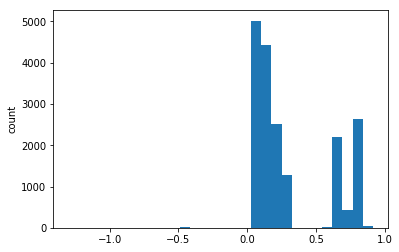

In [13]:
x = flood['value']
x = x[~np.isnan(x)]    # plt.hist needs us to remove NaN values first
plt.hist(x, bins=30)
plt.ylabel('count')
plt.show()

## 3.4 Categorical data<a name="categorical"></a>
Let's look at another column, `flood['town']`, which is not numerical. Let's see the most frequent values and their counts.

In [14]:
vs,ns = np.unique(flood['town'], return_counts=True)  # the unique items, and the count of each
i = np.argsort(-ns)[:5]                                # the indexes of up to 5 items with the highest counts
np.vstack([vs[i], ns[i]]).T                            # show one column for these items, and one for the counts

array([['Cambridge', 7963],
       ['Cam', 2665],
       ['Weston Bampfylde', 2657],
       ['Milton', 2653],
       ['Great Shelford', 2617]], dtype=object)

For convenience, `res.stats.summary` does this tabulation (and also prints out how many further items there are, if any).

In [15]:
summary(flood['town'])

[('Cambridge', 7963),
 ('Cam', 2665),
 ('Weston Bampfylde', 2657),
 ('Milton', 2653),
 ('Great Shelford', 2617)]

Or we can show the distribution of values with a histogram. We have to do the counting ourselves then draw bars with 
[`matplotlib.pyplot.bar`](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.bar).

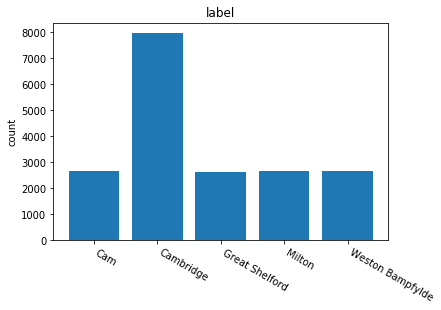

In [16]:
vs,ns = np.unique(flood['town'], return_counts=True)
xs = np.arange(len(vs))                               # pick x-coordinates 0, 1, ..., len(vs)-1
plt.bar(xs, ns, align='center')                       # use width=... to set the bar width
plt.xticks(xs, vs, rotation=-30, ha='left')           # label the x-coordinates of the bars
plt.ylabel('count')
plt.title('label')
plt.show()

## 3.5 Splitting numbers into categories<a name="cut"></a>
Sometimes it's useful to simplify a numerical column by splitting it into categories, e.g. bottom third, middle third, top third. We can find the breakpoints with [`np.percentile`](https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.percentile.html), and find the categories with [`np.digitize`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.digitize.html).

In [17]:
# Each measurement station has its own 'low' and 'high' ranges.
# Let's normalize the values, so that low=0 and high=1, and categorize these normalized values.
x = (flood['value'] - flood['low']) / (flood['high'] - flood['low'])

# np.digitize returns integers saying which bin each number falls in.
# We'll cast it to be a string, so that summary() displays it as categorical.
y = np.digitize(x, bins=np.nanpercentile(x, [100/3, 200/3]))
summary(y.astype(str))

[('1', 6244), ('2', 6192), ('0', 6119)]

Bothersomely, `np.digitize` lumps NaNs into the highest bin, which is misleading. For convenience, `res.stats.cut` takes care of NaNs, and it also gives more helpful labels to the categories.

In [18]:
summary(cut(x, breaks=2))

[('[0.052, 0.368)', 6244),
 ('[0.368, inf)', 6190),
 ('(-inf, 0.052)', 6119),
 ('nan', 2)]

In [25]:
pandas.cut(x, bins=2)

[(-0.329, 1.652], (-0.329, 1.652], (-0.329, 1.652], (-0.329, 1.652], (-0.329, 1.652], ..., (-0.329, 1.652], (-0.329, 1.652], (-0.329, 1.652], (-0.329, 1.652], (-0.329, 1.652]]
Length: 18555
Categories (2, interval[float64]): [(-2.314, -0.329] < (-0.329, 1.652]]

<div style="background-color:wheat"><strong>Excercise.</strong>
The <code style="background-color:wheat">cut</code> function uses 
<code style="background-color:wheat">np.nanpercentile</code> to split the data into equal percentile ranges.
So why are the counts not equal?
</div>

## 3.6 Geographic data<a name="geo"></a>
This data frame has columns `lat` and `lng` which are likely map coordinates. Matplotlib does have routines for map plots (see the [example gallery](https://matplotlib.org/basemap/users/examples.html)), and there are also many contributed libraries of varying quality. Here is a quick and dirty plot on top of Google Maps.

<div style="background-color:red; color:white">
TODO: make sure this output works reliably! Do I need my own maps API token? Different plotting library?
</div>

In [11]:
# Create a numpy Record Array, with one record for each (lat,lng) pair
latlngs = np.rec.fromarrays([flood['lat'], flood['lng']], names=['lat','lng'])
# Count the number of flood readings for each unique (lat,lng)
vs, ns = np.unique(latlngs, return_counts=True)

In [14]:
#!pip3 install gmplot -q                            # install a library for Google Map plots
import gmplot
import IPython.display                              # allows Python code to show html in the notebook

gmap = gmplot.GoogleMapPlotter(52.212, 0.1208, 12)  # define the center of the view, and the zoom level
for lat,lng,n in zip(vs.lat, vs.lng, ns):           # add circles at every (lat,lng) pair  
    gmap.circle(lat, lng, n/10)                     # (though these are too small for a zoomed-out map)

gmap.draw('res/map.html')
IPython.display.IFrame(src='res/map.html', width=600, height=400)

## 3.7 Grouped statistics<a name="groupby"></a>
So far we've only looked at one column at a time. Let's now turn to the relationship between columns (also known as [multivariate analysis](https://en.wikipedia.org/wiki/Multivariate_statistics), as opposed to the univariate analysis we've seen so far). For example, what's the typical range of water levels (`value`) at each measurement station (`label`)? To find this, we need to group the rows of the dataframe, one row for each value of `label`, and for each group we'll compute the mean and standard deviation.

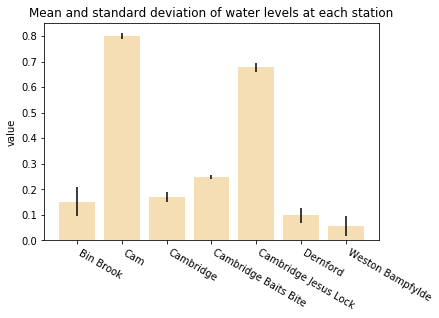

In [30]:
res = {'label':[], 'n':[], 'mean':[], 'sd':[]}
for lbl in np.unique(flood['label']):
    i = flood['label'] == lbl
    res['label'].append(lbl)
    res['n'].append(np.count_nonzero(i))
    res['mean'].append(np.nanmean(flood['value'][i]))
    res['sd'].append(np.nanstd(flood['value'][i]))

# Bar plot, with error bars
xs = np.arange(len(res['label']))
plt.bar(xs, res['mean'], align='center', facecolor='wheat')
plt.errorbar(xs, res['mean'], yerr=res['sd'], linestyle='None', ecolor='k')
plt.xticks(xs, res['label'], rotation=-30, ha='left')
plt.ylabel('value')
plt.title('Mean and standard deviation of water levels at each station')
plt.show()

<div style="background-color:wheat"><strong>Exercise.</strong>
Implement the above code more efficiently, using vectorized operations rather than a <code style="background-color:wheat">for</code> loop. Hint: <a href="https://stackoverflow.com/a/23271510">stackoverflow.com/a/23271510</a>.
What is the complexity of the above code in terms of <em>n</em>, the length of the vector, and <em>k</em>, the number of unique levels?
</div>

## 3.8 Facet plots<a name="facet"></a>
To show more details at each measurement station, we can split the plot out into many subplots, one per station. This is called a _facet plot_ or a _panel plot_ or a _small multiples_ plot. [According to the plotting guru Edward Tufte](https://en.wikipedia.org/wiki/Small_multiple),
<blockquote>
At the heart of quantitative reasoning is a single question: Compared to what? Small multiple designs, multivariate and data bountiful, answer directly by visually enforcing comparisons of changes, of the differences among objects, of the scope of alternatives. For a wide range of problems in data presentation, small multiples are the best design solution.
</blockquote>

This code uses [`fig.add_subplot`](https://matplotlib.org/api/figure_api.html#matplotlib.figure.Figure.add_subplot) to add panels one by one, for each level of `flood['label']`. If we had wanted a two dimensional grid of subplots, split by the levels of two categorical columns, we could have used [`plt.subplots(...)`](https://matplotlib.org/examples/pylab_examples/subplots_demo.html) to create the full grid of panels in one go, as in
[these demos](https://matplotlib.org/examples/pylab_examples/subplots_demo.html).

Previously we have used commands like `plt.hist()` to draw histograms, but this code uses `ax.hist()` where `ax` is an `Axes` object. All the plotting routines are actually [`Axes` methods](https://matplotlib.org/api/axes_api.html), and the `plt.*` methods are just aliases. When you look for code snippets on the web, you'll find both styles.

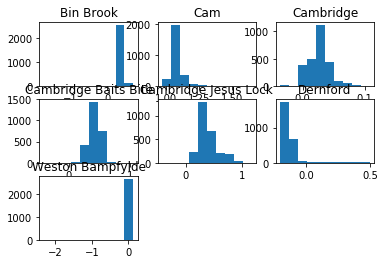

In [31]:
norm_value = (flood['value'] - flood['low']) / (flood['high'] - flood['low'])
labels = np.unique(flood['label'])

fig = plt.figure()
for i,lbl in enumerate(labels):
    ax = fig.add_subplot(3, 3, i+1)        # numrows=3, numcols=3, new subplot in the (i+1)th position
    x = norm_value[flood['label'] == lbl]
    x = x[~np.isnan(x)]                    # remove NaN values since ax.hist doesn't work with them
    ax.hist(x)
    ax.set_title(lbl)

To make the plot look lovely, we need some plot-tweaking.

* `fig.add_subplot` lets us [specify axes to be shared](https://matplotlib.org/users/recipes.html). The code below makes all the subplots share the same x axis as the top left subplot.

* Since all the subplots share the same x axis, but the data for each plot is different, `ax.hist` will choose different bins for each subplot. It looks better to force them all to use the same bins.

* Use `plt.get_cmap(name, n)` to get a colour map with `n` values, where `name` is one of the [standard colour-map names](https://matplotlib.org/users/colormaps.html).

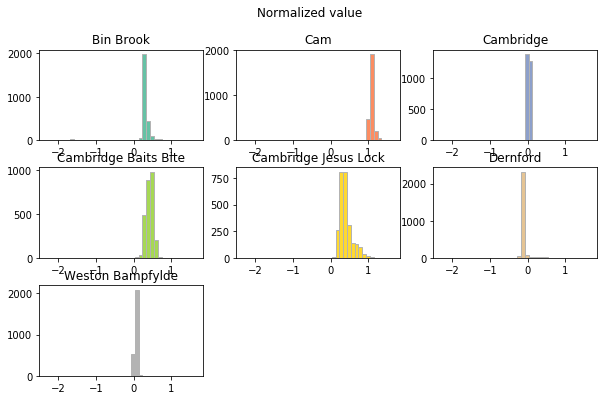

In [30]:
labels = np.unique(flood['label'])
norm_value = (flood['value'] - flood['low']) / (flood['high'] - flood['low'])
bins = np.linspace(min(norm_value), max(norm_value), 40)

with matplotlib.rc_context({'figure.figsize': [10,6], 'figure.subplot.hspace': 0.3}):
    colors = plt.get_cmap('Set2', len(labels))
    fig = plt.figure()
    ax0 = None
    for i,lbl in enumerate(labels):
        if ax0 is None:
            ax = fig.add_subplot(3, 3, i+1)
            ax0 = ax
        else:
            ax = fig.add_subplot(3, 3, i+1, sharex=ax0)
        x = norm_value[flood['label'] == lbl]
        x = x[~np.isnan(x)]
        ax.hist(x, bins=bins, facecolor=colors(i), edgecolor='0.7')
        ax.set_title(lbl)
    fig.suptitle('Normalized value')

<div style="background-color:wheat"><strong>Exercise.</strong>
Which values of <em>i</em> correspond to the three bottom-most panels?
Use <code style="background-color:wheat">ax.get_xaxis().set_visible(False)</code> to turn off the ticks on all the other panels, so the panel labels can be read cleanly.
<em>Solution: if <code style="background-color:wheat">i + 3 &geq; len(labels)</code> then panel <em>i</em> is bottom-most.</em>
</div>

## 3.9 Grouped plots (and timestamps)<a name="grouped"></a>
Here's another way to show grouped data. Again we'll plot each measurement station (`label`) separately, but this time we'll plot the water level (`value`) as a function of time (`t`). The lines for each station can happily fit on the same panel, and we'll add a legend.

The first step is to fix up the time column, so that `matplotlib` knows it's a timestamp and not just a string, so that it will display nicely. As [xkcd](https://www.xkcd.com/1883/) observes, timestamps are a nuisance because of timezones &mdash; and also because of unequal months and leap years and so on, which make it hard work to get axes right in plots.

<a href="https://www.xkcd.com/1883/"><img src="https://imgs.xkcd.com/comics/supervillain_plan.png" style="height:30em" alt="supervillain timezone woes"></a>

In [34]:
import datetime, pytz
x = flood['t']
# Parse the timestamp strings (see https://docs.python.org/3/library/datetime.html#datetime.datetime.strptime)
x = [datetime.datetime.strptime(tstr, '%Y-%m-%dT%H:%M:%SZ') for tstr in x]
# Mark each timestamp as a UTC timestamp
# which is what the docs say they are: http://environment.data.gov.uk/flood-monitoring/doc/reference
x = [t.replace(tzinfo=pytz.utc) for t in x]
# Convert to a local timestamp (which in this case is British Summer Time, one hour off UTC)
local_tz = pytz.timezone('Europe/London')
x = [t.astimezone(local_tz) for t in x]
# Store it in the data frame as a numpy vector, so we can use numpy indexing on it
flood['t2'] = np.array(x)

The plotting code below uses the same core logic for splitting by `label` that we've used before. This time, for each level of `label`, we call `ax.plot(x,y,lbl)`. This picks a different colour each time, and it remembers the association between colours and labels, so that `ax.legend()` can draw the right thing.

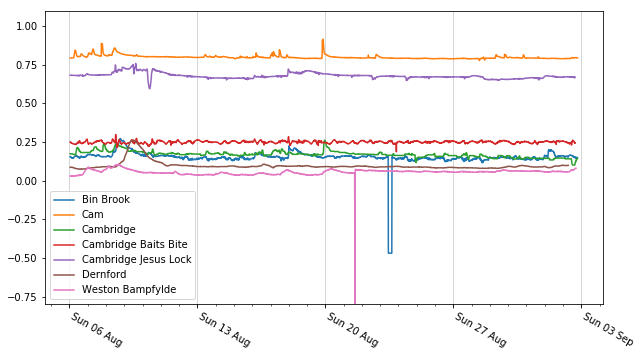

In [36]:
labels = np.unique(flood['label'])

# Set the plot size to be 10x6 nominal inches, for this plot only.
# See https://matplotlib.org/users/customizing.html for more customization options.
with matplotlib.rc_context({'figure.figsize': [10,6]}):
    
    fig,ax = plt.subplots()
    for lbl in labels:
        i = flood['label'] == lbl
        t,v = flood['t2'][i], flood['value'][i]
        # Sort the readings by time, because otherwise the line could go back and forth across the plot
        j = np.argsort(t)
        ax.plot(t[j], v[j], linestyle='-', label=lbl)
    ax.legend()
    
    # Date axis tweaking taken from https://matplotlib.org/examples/api/date_demo.html
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.MO, tz=local_tz))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator(tz=local_tz))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%a %d %b'))
    ax.set_ylim(-0.8, 1.1)
    ax.grid(True, axis='x', color='0.8')
    fig.autofmt_xdate(bottom=0.2, rotation=-30, ha='left')

What is `fig,ax = plt.subplots()` about? The default arguments are [`plt.subplots(nrows=1,ncols=1)`](https://matplotlib.org/api/pyplot_api.html?highlight=matplotlib%20pyplot%20subplots#matplotlib.pyplot.subplots), i.e. it creates a 1&times;1 grid of subplots, and it returns a [`Figure`](https://matplotlib.org/api/figure_api.html#matplotlib.figure.Figure) object and an [`Axes`](https://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes) object. The former has methods for modifying the plot as a whole, and the latter has all the methods for actually plotting data plus methods for tweaking how the axis is shown. When we use `plt.plot()` it's actually just wrapper that retrieves the current axes then calls `ax.plot()`.

## 3.10 Cross tabulation<a name="crosstab"></a>
Cross tabulation lets us see how two or more categorical variables relate to each other. For example, let's find out how many readings there are in each town, and for each river.

In [10]:
# Get the list of unique towns, and let itowns[i] be the town that row i of the dataframe belongs to.
# Likewise for rivers.
towns,itowns = np.unique(flood['town'], return_inverse=True)
rivers,irivers = np.unique(flood['river'], return_inverse=True)
# Create an empty array with one row per town, one column per river
x = np.zeros([len(towns), len(rivers)])
# Tally up the number of readings corresponding to each cell of the array.
for it,ir in zip(itowns, irivers):
    x[it,ir] += 1
x

array([[    0.,  2665.],
       [ 2665.,  5298.],
       [    0.,  2617.],
       [    0.,  2653.],
       [    0.,  2657.]])

It's painful to have to write multiple lines of code every time we want a simple cross tabulation, and the output doesn't show row and column labels. This is where library routines come into their own, specifically 
[`pandas.crosstab`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html)
and [`pivot_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pivot_table.html) and [`unstack`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.unstack.html#pandas.DataFrame.unstack). The `pandas` syntax is powerful but takes some getting used to, so instead here's a simple wrapper function, `res.stats.crosstab`.

In [25]:
crosstab('town', 'river', data=flood)

river,Bin Brook,River Cam
town,,
Cam,0,2665
Cambridge,2665,5298
Great Shelford,0,2617
Milton,0,2653
Weston Bampfylde,0,2657


Cross-tabulation is useful for figuring out the contents of a data set you've been given. Let's work out how many measurement stations there are for each town and each river:

In [26]:
# Produce a data frame x with one row per town:river:measure_id.
# (crosstab produces a table by default, but with format_='DataFrame' it produces a pandas.DataFrame.)
x = crosstab('town','river','measure_id', data=flood, format_='DataFrame')
# For each town:river, how many rows does x have i.e. how many measurement stations?
crosstab('town', 'river', data=x)

river,Bin Brook,River Cam
town,,
Cam,0,1
Cambridge,1,2
Great Shelford,0,1
Milton,0,1
Weston Bampfylde,0,1


<div style="background-color:wheat"><strong>Exercise.</strong>
(Advanced practice at <code style="background-color:wheat">numpy</code> vectorized coding.)
Rewrite the explicit tabulation code, using vectorized operations rather than a <code style="background-color:wheat">for</code> loop.
<em>Solution:</em>
<pre style="background-color:wheat">
idx,ns = np.unique(np.vstack([itowns,irivers]).T, axis=0, return_counts=True)
x = np.zeros([len(towns), len(rivers)])
x[tuple(idx.T)] = ns
</pre>
</div>

## 3.11 Merging dataframes<a name="merge"></a>
Consider these two questions about the flood data:

* We've seen how to compute the mean and standard deviation of water level at each measurement station. How can we use these to standardize all the readings, per station?
* How can we compute the weekly rate of change at each station, i.e. the average value in a week, minus the value in the previous week?

These are questions that we can answer by merging dataframes, or `JOIN`ing them as it's referred to in IA _Databases_. 
It's possible to implement this yourself in plain Python, but there's no reason not to use
[`pandas.DataFrame.merge()`](https://pandas.pydata.org/pandas-docs/stable/merging.html#database-style-dataframe-joining-merging).
Here is a simple example.

In [29]:
# Find the mean and standard deviation per station, as in Section 3.5.
stations = {'label':[], 'mean':[], 'sd':[]}
for lbl in np.unique(flood['label']):
    i = flood['label'] == lbl
    stations['label'].append(lbl)
    stations['mean'].append(np.nanmean(flood['value'][i]))
    stations['sd'].append(np.nanstd(flood['value'][i]))

# Do the merge, and (optionally) convert it back to a plain Python dictionary
flood2 = pandas.DataFrame(flood).merge(pandas.DataFrame(stations), on='label')
flood2 = OrderedDict((k, v.values) for k,v in flood2.items())

The same plotting code as in Section 3.7, but applied to the standardized values `(flood2['value']-flood2['mean'])/flood2['sd']` now looks like this:
![standardized water levels](res/normts.png)

<div style="background-color:wheat"><strong>Exercise.</strong>
To compute weekly rate of change, what two dataframes should we merge, and what join key should we use? 
<em>Hint: the join key should be a list of two column names.</em>.
</div>